In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow_datasets as tfds
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

from tensorflow import keras
from keras import layers

import pandas as pd

Training dataset: 5994
Test dataset: 5794


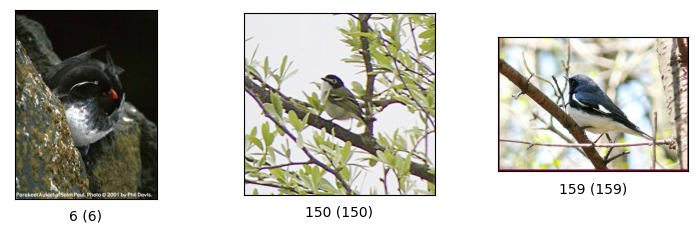

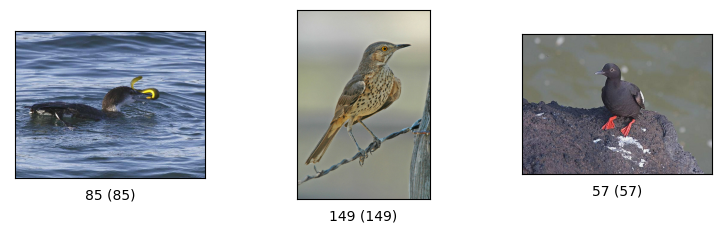

In [2]:
# Settings
batch_size = 8
img_width = 320
img_height = 320

# Fetch dataset
(train_ds_original, test_ds_original), ds_info = tfds.load(
    'caltech_birds2011', 
    split=['train', 'test'], 
    as_supervised=True, 
    shuffle_files=True, 
    with_info=True,
)

# Display dataset
print("Training dataset: {0}".format(len(train_ds_original)))
print("Test dataset: {0}".format(len(test_ds_original)))

fig = tfds.show_examples(train_ds_original.take(3), ds_info, image_key='image')
fig = tfds.show_examples(test_ds_original.take(3), ds_info, image_key='image')

In [3]:
# Data augmentation
augmentation = keras.Sequential([
    layers.RandomContrast(factor=0.1),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
])

num_classes = 3
filter_labels = lambda image, label: label == 0 or label == 1 or label == 2

indices = list(range(0, num_classes))
new_labels = tf.one_hot(indices, num_classes)

def modify_images(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    image = tf.image.resize_with_pad(
        image,
        img_height, img_width,
        method='bilinear',
        antialias=False,
    )
    
    image = augmentation(image)
    
    return image, new_labels[label]

# Prepear dataset
train_ds = (
    train_ds_original
    .filter(filter_labels)
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_ds = (
    test_ds_original
    .filter(filter_labels)
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Display dataset
# print("Training dataset: {0}".format(len(list(train_ds))))
# print("Test dataset: {0}".format(len(list(test_ds))))

# fig = tfds.show_examples(train_ds.take(3), ds_info, image_key='image')
# fig = tfds.show_examples(test_ds.take(3), ds_info, image_key='image')

# Batch dataset
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [4]:
# Setup model
model = keras.Sequential([
    # Input
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Rescaling(scale=1./255),

    # Block 1
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block 3
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Block 4
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

# Summarize model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 320, 320, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 320, 320, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 320, 320, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 160, 160, 64)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 160, 160, 64)     256       
 hNormalization)                                                 
                                                      

In [5]:
# Prepear model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

# Train model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=32,
)

# Save model
model.save("output/m2")

Epoch 1/32
12/12 [==============================] - 21s 1s/step - loss: 26.1945 - accuracy: 0.3667 - val_loss: 11.9158 - val_accuracy: 0.3409
Epoch 2/32
12/12 [==============================] - 1s 87ms/step - loss: 13.2137 - accuracy: 0.3556 - val_loss: 30.2541 - val_accuracy: 0.3409
Epoch 3/32
12/12 [==============================] - 1s 86ms/step - loss: 5.6926 - accuracy: 0.5000 - val_loss: 2.7928 - val_accuracy: 0.3182
Epoch 4/32
12/12 [==============================] - 1s 86ms/step - loss: 2.0181 - accuracy: 0.5444 - val_loss: 1.9480 - val_accuracy: 0.3182
Epoch 5/32
12/12 [==============================] - 1s 86ms/step - loss: 1.1541 - accuracy: 0.5222 - val_loss: 1.6502 - val_accuracy: 0.3182
Epoch 6/32
12/12 [==============================] - 1s 89ms/step - loss: 1.2453 - accuracy: 0.6556 - val_loss: 2.6984 - val_accuracy: 0.3182
Epoch 7/32
12/12 [==============================] - 1s 86ms/step - loss: 0.9872 - accuracy: 0.7222 - val_loss: 3.1190 - val_accuracy: 0.3182
Epoch 8/32

<AxesSubplot: >

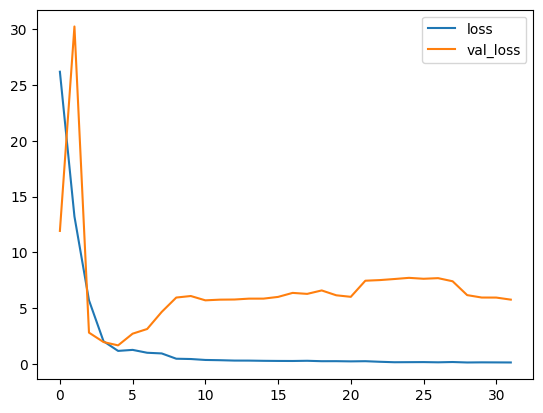

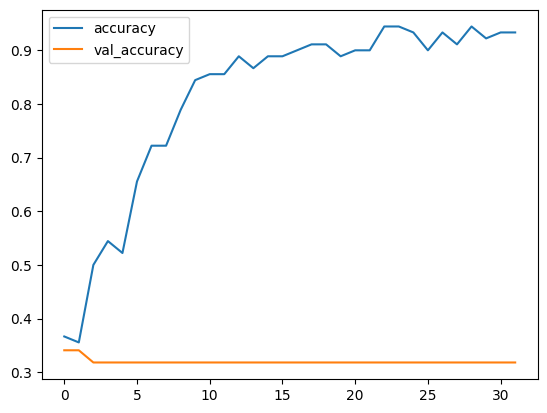

In [6]:
# Plot learning curves
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()